In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
# IMAGE = "images/63d32765e0ad4c0e994e910b81a8a835.jpg"
IMAGE = "images/d10513b8500a4a48a6327eeceae5868c.jpg"
MODEL_PATH = "../models/best.pt"
model = YOLO(MODEL_PATH)
frame = cv2.imread(IMAGE)
results = model(frame)


0: 768x1024 4 bottles, 4 caps, 110.2ms
Speed: 32.9ms preprocess, 110.2ms inference, 3.1ms postprocess per image at shape (1, 3, 768, 1024)


In [3]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, parameters)

CORNER_MARKERS = [8, 2, 1, 7]
plane_points = np.array([
    [0, 0],
    [170, 0],
    [170, 80],
    [0, 80]
], dtype=np.float32)

In [4]:
def detect_all_markers(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = detector.detectMarkers(gray)
    return corners, ids

In [5]:
def get_plane_markers(corners, ids):
    if ids is None:
        return None

    ids = ids.flatten()
    pts = {}

    for corner, id_ in zip(corners, ids):
        if id_ in CORNER_MARKERS:
            c = corner[0]
            center = np.mean(c, axis=0)
            pts[id_] = center

    if len(pts) != 4:
        return None

    ordered = np.array([pts[i] for i in CORNER_MARKERS], dtype=np.float32)
    return ordered

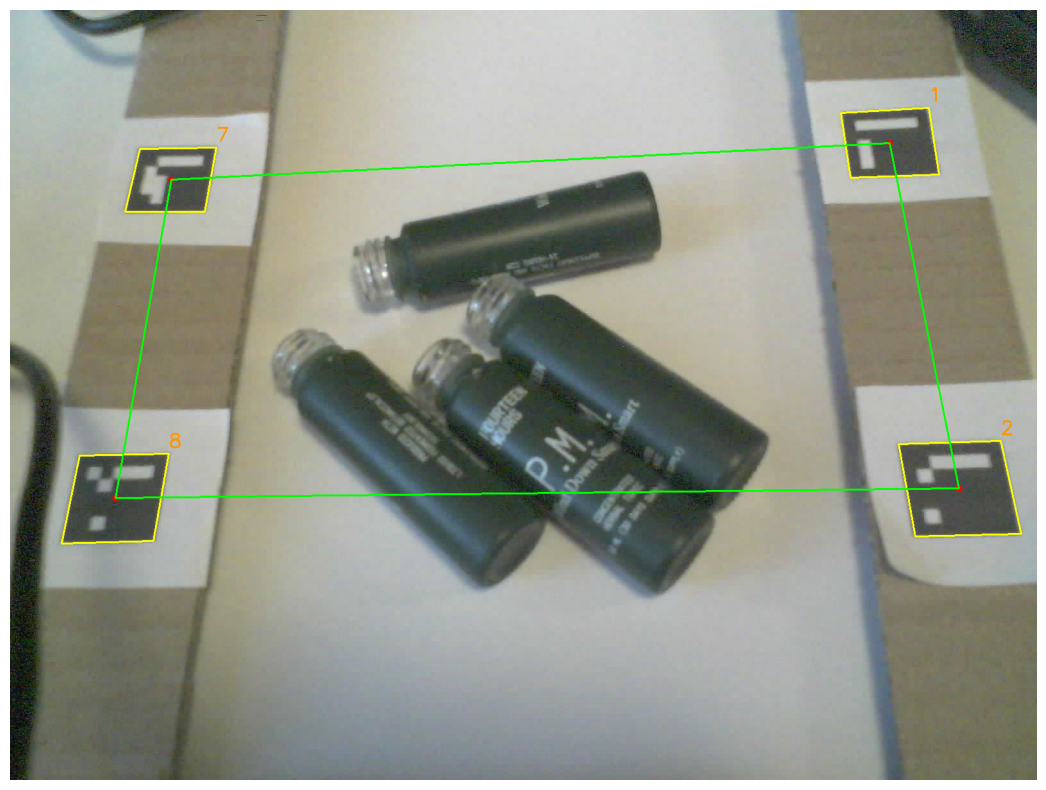

In [6]:
corners, ids = detect_all_markers(frame)

if ids is not None:
    for corner, id_ in zip(corners, ids.flatten()):
        pts = corner[0].astype(int)

        cv2.polylines(frame, [pts], True, (0, 255, 255), 2)

        center = tuple(np.mean(pts, axis=0).astype(int))
        cv2.circle(frame, center, 5, (0, 0, 255), -1)

        cv2.putText(frame, f"{id_}", (pts[0][0], pts[0][1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 150, 255), 2)

plane_markers = get_plane_markers(corners, ids)
if plane_markers is not None:
    H, _ = cv2.findHomography(plane_markers, plane_points)

    pts = np.float32(plane_points).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, np.linalg.inv(H))
    dst = np.int32(dst)

    cv2.polylines(frame, [dst], True, (0, 255, 0), 2)

plt.figure(figsize=(40,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

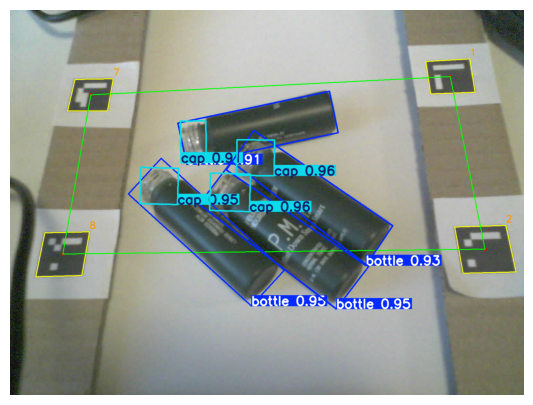

In [7]:
annotated = results[0].plot()

plt.figure(figsize=(20,5))
plt.axis("off")
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))

In [8]:
print(results[0].obb)

ultralytics.engine.results.OBB object with attributes:

cls: tensor([1., 1., 1., 0., 0., 0., 1., 0.])
conf: tensor([0.9632, 0.9600, 0.9547, 0.9506, 0.9481, 0.9275, 0.9109, 0.9085])
data: tensor([[6.8487e+02, 5.6830e+02, 1.2358e+02, 1.1663e+02, 2.7401e-02, 9.6318e-01, 1.0000e+00],
        [7.6462e+02, 4.6031e+02, 1.1687e+02, 1.1094e+02, 7.3769e-03, 9.6001e-01, 1.0000e+00],
        [4.6408e+02, 5.4821e+02, 1.1729e+02, 1.1277e+02, 2.5215e-02, 9.5466e-01, 1.0000e+00],
        [8.5242e+02, 7.0225e+02, 5.3774e+02, 1.6697e+02, 6.5318e-01, 9.5062e-01, 0.0000e+00],
        [6.1105e+02, 6.9266e+02, 5.1768e+02, 1.5101e+02, 7.3953e-01, 9.4809e-01, 0.0000e+00],
        [9.3296e+02, 5.8579e+02, 5.2549e+02, 1.5004e+02, 6.0198e-01, 9.2751e-01, 0.0000e+00],
        [5.7087e+02, 4.1117e+02, 1.2943e+02, 7.9187e+01, 1.5577e+00, 9.1090e-01, 1.0000e+00],
        [7.7203e+02, 3.6744e+02, 1.3176e+02, 4.8142e+02, 1.3632e+00, 9.0847e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1200, 1600)
shape: tor

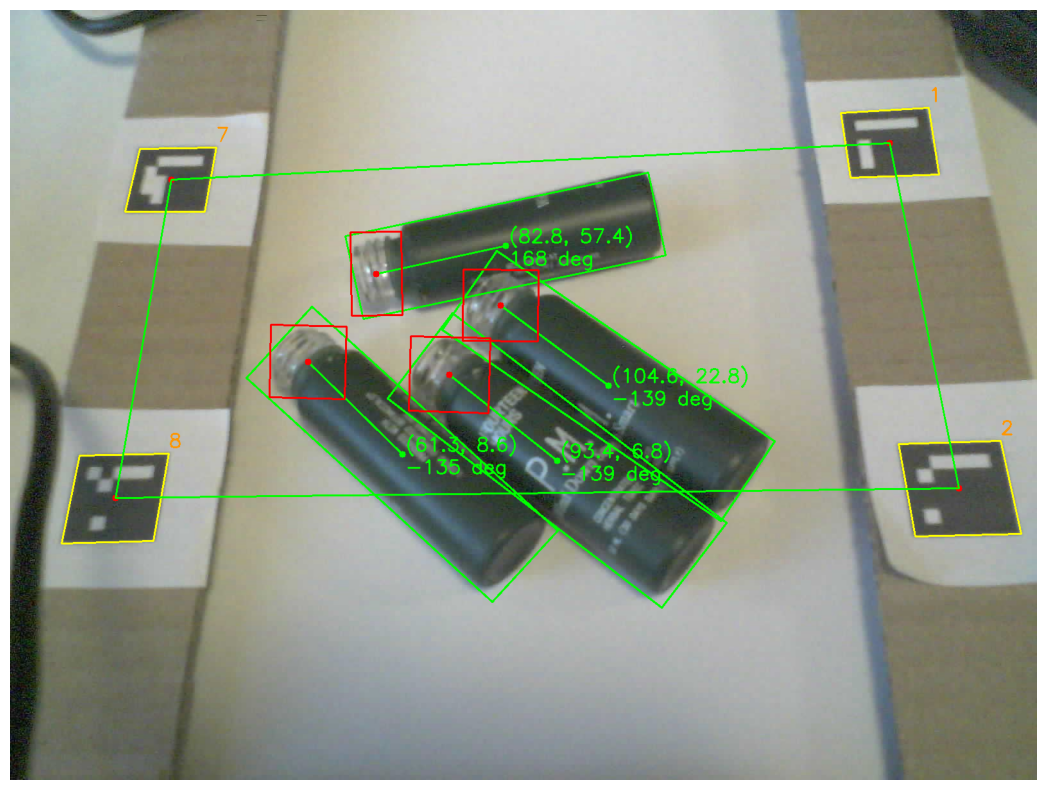

In [9]:
f_copy = frame.copy()
r = results[0]

bottles = []
caps = []

img_h, img_w = r.orig_shape

# Разделяме обектите по клас
for i in range(len(r.obb)):
    box_obj = r.obb[i]
    cls_name = results[0].names[int(box_obj.cls[0])]
    x, y, w, h, angle = box_obj.xywhr[0].cpu().numpy()  # normalized
    pts = box_obj.xyxyxyxy[0].cpu().numpy().astype(np.int32)
    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)

    pix = np.array([[x, y, 1]], dtype=np.float32).T
    pt = H @ pix
    pt /= pt[2]
    coords = (pt[0][0], pt[1][0])
    
    obj = {
        "center": (int(x), int(y)),
        "angle": angle,
        "pts": pts,
        "mask": mask,
        "conf": r.obb[i].conf[0].item(),
        "coords": coords
    }
    
    if cls_name == 'bottle':
        bottles.append(obj)
    elif cls_name == 'cap':
        caps.append(obj)
# Визуализация
for i in range(len(bottles)):
    # маска на bottle

    # проверка кои caps са изцяло вътре
    b = bottles[i]
    b['cap'] = None
    best_coverage = 0.5
    for c in caps:
        count = cv2.countNonZero(cv2.bitwise_and(b['mask'], c['mask']))
        coverage = count / cv2.countNonZero(c['mask'])
        if coverage > best_coverage:
            b['cap'] = c['center']
            b['cap_coords'] = c['coords']

    b['orientation'] = 0
    if b['cap'] is not None:
        bottle_center = np.array(b['coords'])
        cap_center = np.array(b['cap_coords'])

        vec = cap_center - bottle_center

        angle = np.degrees(np.arctan2(vec[0], vec[1])) + 90

        orientation = angle % 360 - 180
        b['orientation'] = orientation

for b in bottles:
    if b['cap'] is None:
        continue

    cv2.drawContours(frame, [b["pts"]], -1, (0, 255, 0), 2)
    cv2.line(frame, b["center"], b["cap"], color=(0, 255, 0), thickness=2)
    cv2.circle(frame, b["center"], 5, (0, 255, 0), -1)
    cv2.putText(frame, f"({b['coords'][0]:.1f}, {b['coords'][1]:.1f})",
                (b["center"][0] + 5, b["center"][1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"{int(b['orientation'])} deg",
                (b["center"][0] + 5, b["center"][1] + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

for c in caps:
    cv2.drawContours(frame, [c["pts"]], -1, (0, 0, 255), 2)
    cv2.circle(frame, c["center"], 5, (0, 0, 255), -1)

plt.figure(figsize=(40,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

frame = f_copy